In [1]:
# load the black code formatter for jupyter lab
%load_ext lab_black

This very simple notebook will take a blood pressure reading log (the provided example data is produced by an OMRON Smart X reader), allocate the readings to three sections of the day (AM, MID and PM) and draw a boxplot to perform a first rough estimate about the presence of a trend. Then plot the measurements in time to give an idea of the trend.

Import needed libraries

In [2]:
# One ring to handle numbers
import numpy as np
import pandas as pd
import scipy.stats as stats

# One ring to handle time
import datetime as dt
from datetime import date
import time

# One ring to draw reality
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# and One ring to rule them all ;)
# from matplotlib.dates import date2num

Set the (arbitrary) limits to divide the day in an AM, MID(day) and PM areas and the name of data file

In [3]:
AM_LIMIT = 10
PM_LIMIT = 16
LOGNAME = "data/new_bp_log.csv"
# LOGNAME = '../input/blood-pressure-readings/bp_log.csv' # on Kaggle
# https://www.kaggle.com/rjalexander/blood-pressure-circadian
bpstage_names = ["normal", "elevated", "stage1", "stage2", "crisis"]
bpstage_color = ["#aecd55", "#fcec4f", "#f4b93f", "#ad451d", "#8c1e1b"]
bp_stages = {
    "normal": "#aecd55",
    "elevated": "#fcec4f",
    "stage1": "#f4b93f",
    "stage2": "#ad451d",
    "crisis": "#8c1e1b",
}

### Define some functions:

In [4]:
def classify_bp(row):
    """
    Categorize the BP level as per guidelines
    """
    if row.SYS < 120 and row.DIA < 80:
        return "normal"
    elif (row.SYS >= 120 and row.SYS <= 129) and row.DIA < 80:
        return "elevated"
    elif (row.SYS >= 130 and row.SYS <= 139) or (row.DIA >= 80 and row.DIA <= 89):
        return "stage1"
    elif (row.SYS >= 140 and row.SYS <= 179) or (row.DIA >= 90 and row.DIA <= 119):
        return "stage2"
    elif row.SYS > 180 or row.DIA > 120:
        return "crisis"

In [5]:
def partofday(hour):
    """
    generate a "partofday" categorical label based on the hour of the blood pressure reading and the limits we set above
    """
    if hour <= AM_LIMIT:
        return "AM"
    elif hour > AM_LIMIT and hour <= PM_LIMIT:
        return "MID"
    else:
        return "PM"

In [6]:
def regplot_of_df(df, barwidth):
    """
    Regression plot of SYStolic and DIAstolic values passed to it
    Each pair of reading connected by a vertical line superposing a barplot
    The vertical bar lines are colored accordingly to the bp_stages dictionary
    and to the classification of that reading's stage as per the classify_bp function
    Second parameter needs adjustement according to the number of X values
    """
    plt.figure(figsize=(44, 16))
    # as the scattterplot does not accept a datetime timestamp as the x values, I am using the epoch in the "elapsed_seconds" column
    ax = sns.regplot(x="unix", y="SYS", data=df, label="SYS", scatter_kws={"s": 100})
    ax = sns.regplot(x="unix", y="DIA", data=df, label="DIA", scatter_kws={"s": 100})
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    # set some other visuals
    ax.set_xlabel("Measurement Date", fontsize=28, labelpad=20)
    ax.set_ylabel("Arm cuff BP (mmHg)", fontsize=28)
    plt.legend(prop={"size": 20})
    # now add a vertical bar joining the SYS and DIA readings
    plt.bar(
        x=df["unix"],
        height=df["SYS"] - df["DIA"],
        bottom=df["DIA"],
        width=barwidth,
        color=df["bp_color"],
    )
    # create some whitespace horizontally around the plot values
    ax.set_xlim(df["unix"].min() - 10000, df["unix"].max() + 10000)
    # now convert the epoch values back to a YYYY-MM-DD string for the x labels
    # localtime converts the epoch into a datetime object, and strftime converts it into a string
    new_labels = [
        time.strftime("%Y-%m-%d", time.localtime(item)) for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels)
    plt.show()

## NOW read the CSV data and rename and add a few fields

In [7]:
df = pd.read_csv(LOGNAME)

In [8]:
# recreate a Measurement Date text field field like in the old log format to reuse older code
df["Measurement Date"] = df["Date"] + " " + df["Time"]
# also rename the systolic (SYS) and diastolic (DIA) and pulse (Pulse) columns with the old log format names
df.rename(
    columns={
        "Systolic (mmHg)": "SYS",
        "Diastolic (mmHg)": "DIA",
        "Pulse (bpm)": "Pulse",
    },
    inplace=True,
)

### Add a datetime column and a couple of derived ordinals


In [9]:
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"]
)  # generate a datetime object from the two Date and Time strings
df["unix"] = (
    df["datetime"].astype("int64") / 1e9
)  # generate seconds from Unix epoch from the datetime object
df["elapsed_seconds"] = (
    df["datetime"] - df["datetime"].min()
).dt.total_seconds()  # generate seconds from earliest observation time

### Add a new "partofday" categorical new column in the dataframe

In [10]:
### using apply and partofday function superseded by the mask method below
# df["partofday"] = df.apply(
#    lambda row: partofday(pd.to_datetime(row["Measurement Date"]).hour), axis=1
# )
maskAM = df[df["datetime"].dt.hour < 11].index
maskPM = df[df["datetime"].dt.hour > 17].index
df.insert(1, "partofday", "MID")
df.loc[maskAM, "partofday"] = "AM"
df.loc[maskPM, "partofday"] = "PM"

### Also add a BP stage category (normal, elevated, stage1, stage2, crisis) and show relative frequency

In [11]:
df["bp_stage"] = df.apply(classify_bp, axis=1)

### Add a bp_color column with the Hex color value corresponding to the BP stage as per the bp_stages dictionary

In [12]:
df["bp_color"] = df[
    "bp_stage"
]  # add a BP stage classification (bp_stage) column to the dataframe
df["bp_color"] = df["bp_color"].map(bp_stages)

### Now just drop currently unneeded columns, just for being frugal :)

In [13]:
df.drop(
    [
        "Irregular heartbeat detected",
        "Body Movement",
        "Cuff wrap guide",
        "Positioning Indicator",
        "Measurement Mode",
        "Possible Afib",
        "Device",
        "Notes",
    ],
    inplace=True,
    axis=1,
)

In [14]:
df

,Date,partofday,Time,SYS,DIA,Pulse,Measurement Date,datetime,unix,elapsed_seconds,bp_stage,bp_color
0,04 Jul 2022,AM,09:58,88,61,72,04 Jul 2022 09:58,2022-07-04 09:58:00,1.656929e+09,36543240.0,normal,#aecd55
1,02 Jul 2022,AM,10:01,111,69,62,02 Jul 2022 10:01,2022-07-02 10:01:00,1.656756e+09,36370620.0,normal,#aecd55
2,02 Jul 2022,MID,14:17,113,69,64,02 Jul 2022 14:17,2022-07-02 14:17:00,1.656771e+09,36385980.0,normal,#aecd55
3,01 Jul 2022,MID,12:15,114,73,65,01 Jul 2022 12:15,2022-07-01 12:15:00,1.656678e+09,36292260.0,normal,#aecd55
4,01 Jul 2022,MID,16:59,113,76,65,01 Jul 2022 16:59,2022-07-01 16:59:00,1.656695e+09,36309300.0,normal,#aecd55
...,...,...,...,...,...,...,...,...,...,...,...,...
87,10 May 2021,AM,07:22,124,81,63,10 May 2021 07:22,2021-05-10 07:22:00,1.620631e+09,245880.0,stage1,#f4b93f
88,09 May 2021,PM,21:43,118,73,68,09 May 2021 21:43,2021-05-09 21:43:00,1.620597e+09,211140.0,normal,#aecd55
89,08 May 2021,AM,09:17,125,72,63,08 May 2021 09:17,2021-05-08 09:17:00,1.620465e+09,79980.0,elevated,#fcec4f
90,07 May 2021,MID,11:04,135,81,77,07 May 2021 11:04,2021-05-07 11:04:00,1.620385e+09,0.0,stage1,#f4b93f


### Show how many of the readings are in each BP class

In [15]:
# count how many ocurrences of each BP reading per BP class
bp_cat_freq = df["bp_stage"].value_counts()

In [16]:
bp_cat_freq

normal      43
stage1      34
elevated    15
Name: bp_stage, dtype: int64

<AxesSubplot:>

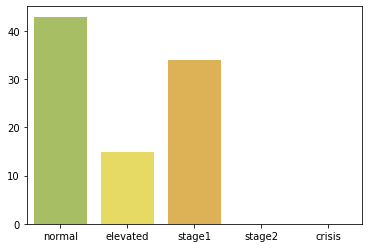

In [17]:
# reindex the data
plot_data = bp_cat_freq.reindex(bpstage_names)
sns.barplot(x=plot_data.index, y=plot_data.values, palette=bpstage_color)

### Now plot the SYS(tolic) and then the DIA(stolic) pressure values divided in the three sections of the day

In [18]:
sns.set_theme(style="whitegrid")

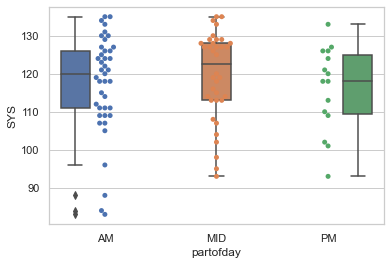

In [19]:
ax = sns.boxplot(
    x=df["partofday"],
    y=df["SYS"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax = sns.swarmplot(
    x=df["partofday"],
    y=df["SYS"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax.legend_.remove()

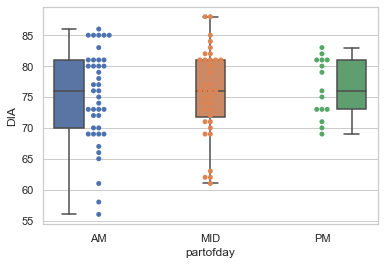

In [20]:
ax = sns.boxplot(
    x=df["partofday"],
    y=df["DIA"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax = sns.swarmplot(
    x=df["partofday"],
    y=df["DIA"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax.legend_.remove()

### Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and PM

In [21]:
stats.ttest_ind(df["SYS"][df["partofday"] == "AM"], df["SYS"][df["partofday"] == "PM"])

Ttest_indResult(statistic=0.3362449395764959, pvalue=0.73798929906982)

In [22]:
stats.ttest_ind(df["DIA"][df["partofday"] == "AM"], df["DIA"][df["partofday"] == "PM"])

Ttest_indResult(statistic=-0.6999605996820649, pvalue=0.4869565922340462)

Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and MIDday

In [23]:
stats.ttest_ind(df["SYS"][df["partofday"] == "AM"], df["SYS"][df["partofday"] == "MID"])

Ttest_indResult(statistic=-0.7959959054035455, pvalue=0.4285467073251008)

In [24]:
stats.ttest_ind(df["DIA"][df["partofday"] == "AM"], df["DIA"][df["partofday"] == "MID"])

Ttest_indResult(statistic=-0.46615825450959764, pvalue=0.6424533166615963)

#### Conclusion: no significant distribution variability of blood presure values between the three daily phases 

### Let's now plot the BP values and see what's their temporal trend in time

/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_25833/2181959774.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


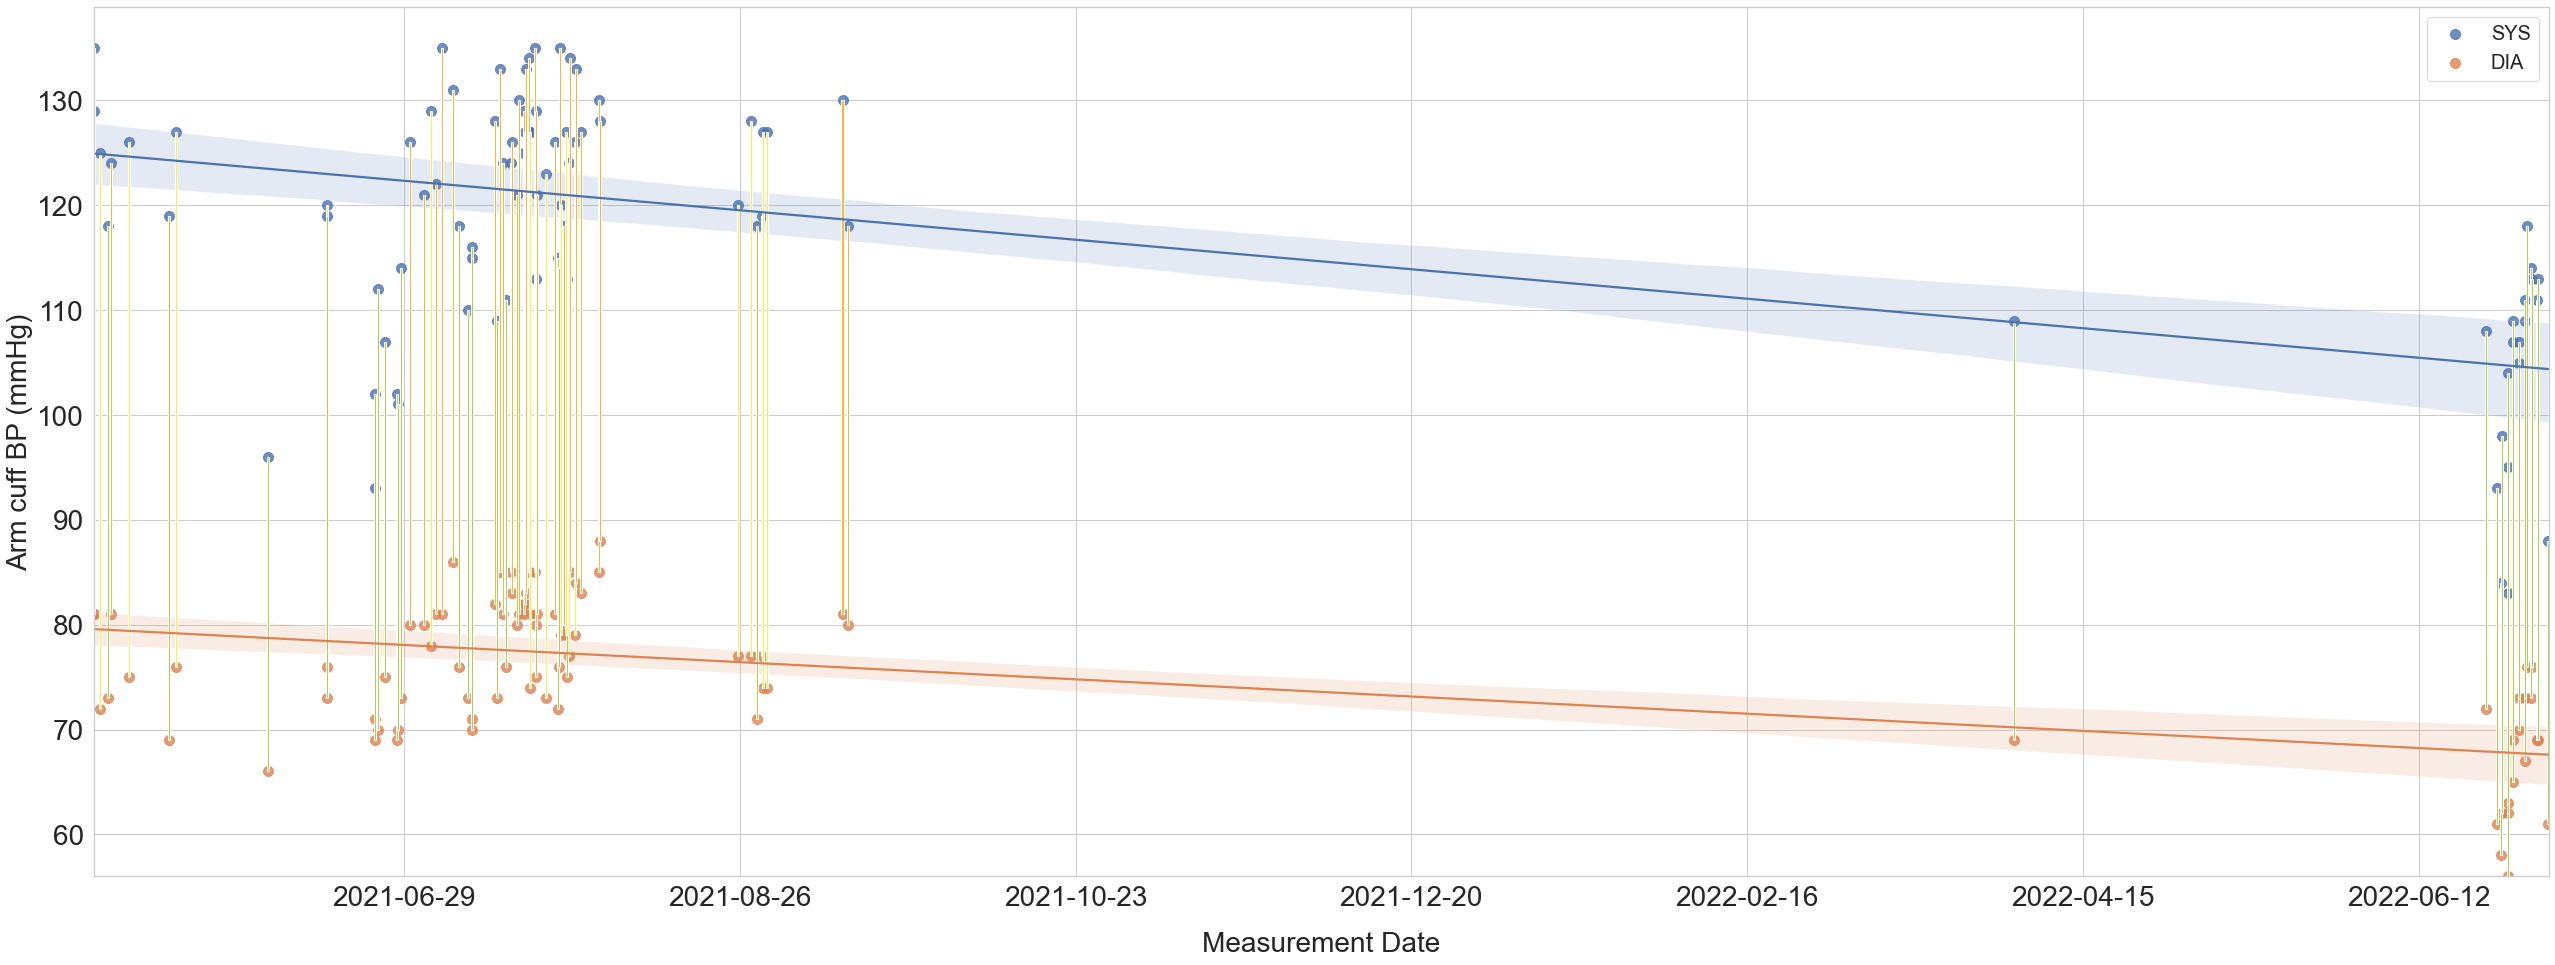

In [25]:
regplot_of_df(df, 30000)

### Extract the data subset for last week and last 30 days measurments

In [26]:
today = date.today()
week_prior = today - dt.timedelta(weeks=1)
month_prior = today - dt.timedelta(days=30)
df_lastweek = df[df["datetime"].dt.date >= week_prior]
df_lastmonth = df[df["datetime"].dt.date >= month_prior]

# Now describe last week measurements if available

In [27]:
df_lastweek.describe()

,SYS,DIA,Pulse,unix,elapsed_seconds
count,12.000000,12.000000,12.000000,1.200000e+01,1.200000e+01
mean,108.750000,70.083333,66.750000,1.656617e+09,3.623146e+07
std,7.448307,4.440687,3.768892,1.568653e+05,1.568653e+05
min,88.000000,61.000000,62.000000,1.656410e+09,3.602442e+07
25%,107.000000,68.500000,64.750000,1.656490e+09,3.610504e+07
50%,110.000000,69.500000,66.000000,1.656598e+09,3.621240e+07
75%,113.000000,73.000000,68.250000,1.656710e+09,3.632463e+07
max,118.000000,76.000000,73.000000,1.656929e+09,3.654324e+07


/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_25833/2181959774.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


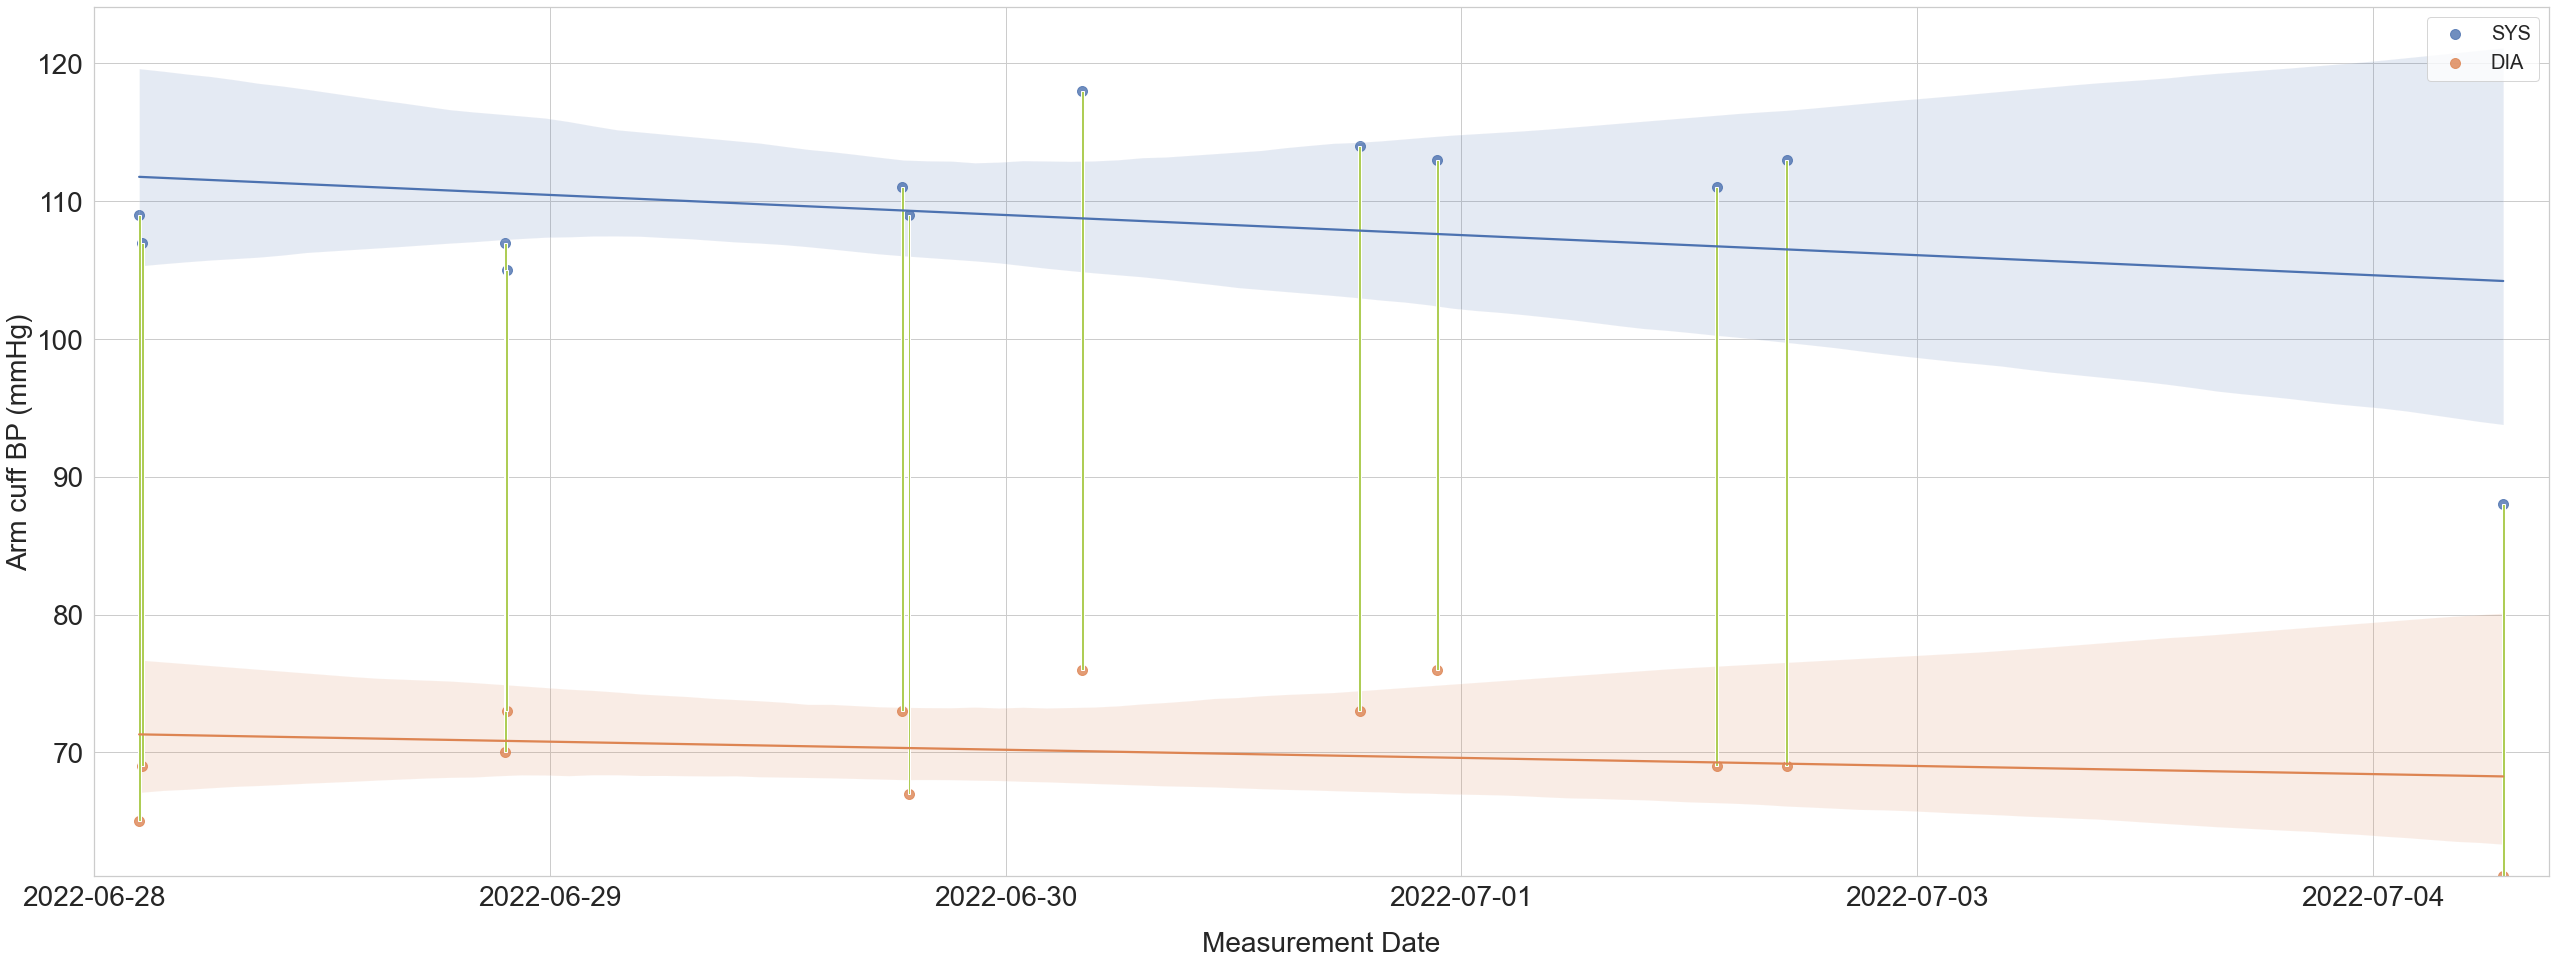

In [28]:
regplot_of_df(df_lastweek, 600)

# Now describe last 30 days measurements and plot them (if different from last week)

In [29]:
if not df_lastweek.equals(df_lastmonth):
    df_lastmonth.describe()  #### to be remove when the following statement will work

In [31]:
df_lastmonth.describe() # this nevessary until the if in the call above does not work

,SYS,DIA,Pulse,unix,elapsed_seconds
count,19.000000,19.000000,19.000000,1.900000e+01,1.900000e+01
mean,103.684211,67.105263,67.315789,1.656476e+09,3.609065e+07
std,10.472465,6.054335,3.266881,2.356751e+05,2.356751e+05
min,83.000000,56.000000,62.000000,1.656005e+09,3.561996e+07
25%,96.500000,62.000000,65.000000,1.656327e+09,3.594171e+07
50%,107.000000,69.000000,67.000000,1.656490e+09,3.610482e+07
75%,111.000000,72.500000,69.500000,1.656647e+09,3.626184e+07
max,118.000000,76.000000,73.000000,1.656929e+09,3.654324e+07


/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_25833/2181959774.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


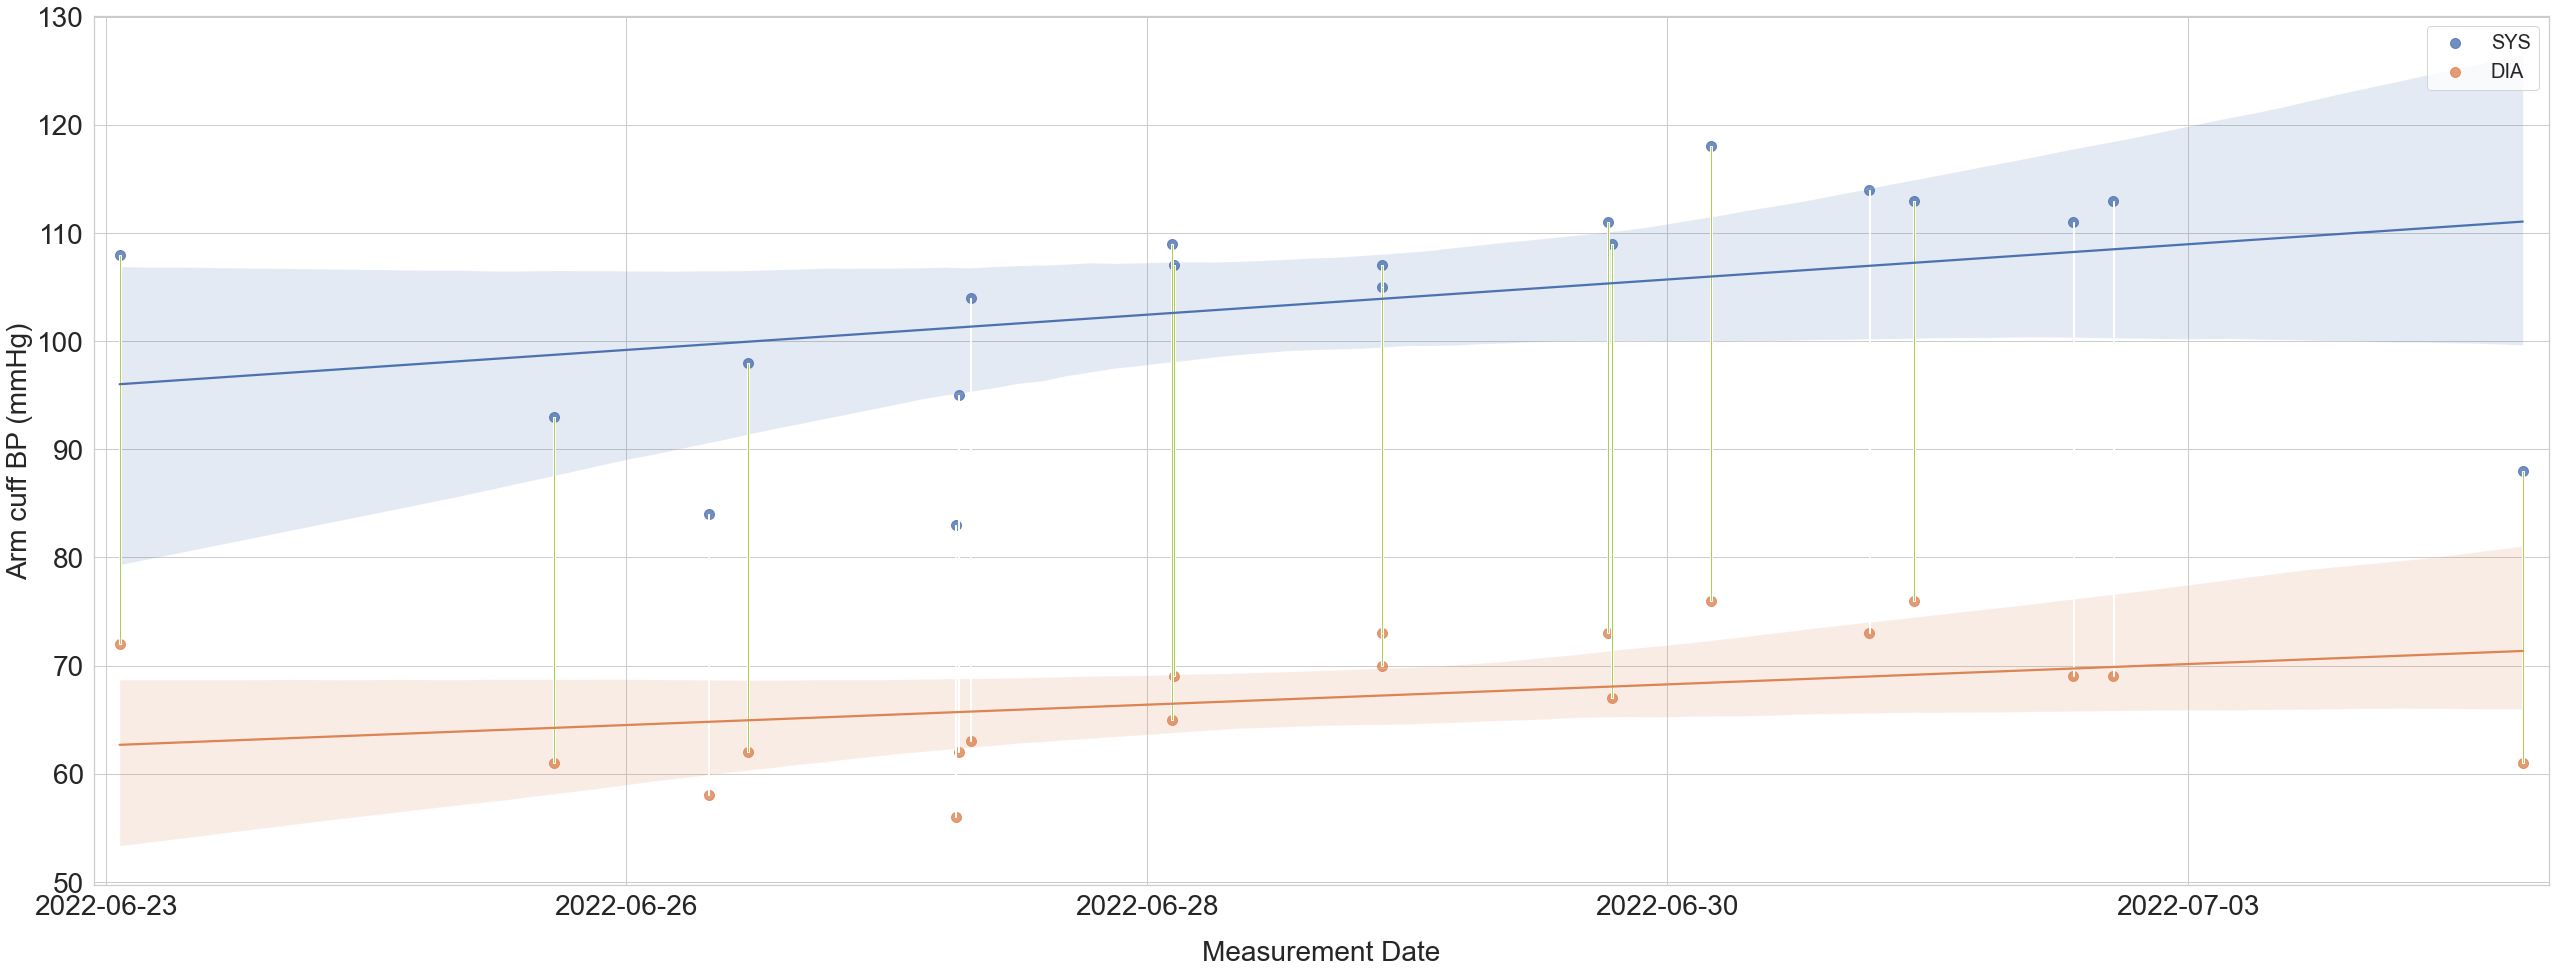

In [30]:
if not df_lastweek.equals(df_lastmonth):
    regplot_of_df(df_lastmonth, 700)